In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rp
from prediction_pipeline.preprocessing import *

In [70]:
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"
pheno_cols = ["ADP_PSEL","ADP_FIB","ADP",
               "CRP_PSEL","CRP_FIB","CRP",
               "TRAP_PSEL","TRAP_FIB","TRAP",
               "PAR1_PSEL","PAR1_FIB","PAR1",
               "PAR4_PSEL","PAR4_FIB","PAR4"]

# Load

In [83]:
all_pheno_df = pd.read_csv("%s/metadata_PF/PLATELET_FUNCTION_KD_11062019.txt" % data_dir,sep="\t")
#all_pheno_df.loc[all_pheno_df.PROJECT == "PFC_4_U","PROJECT"] = "PFC_4"
del all_pheno_df["TIME"]

In [84]:
df = all_pheno_df.copy()

# Logit-normalize

In [85]:
agonists = ["ADP","CRP","TRAP","PAR1","PAR4"]

# Move to logit and normalize

for c in df.columns:
    is_fc_measurement = False
    for ago in agonists + ["REST"]:
        if ago in str(c):
            is_fc_measurement = True
            break
    if is_fc_measurement == True:
        if df[c].dtype == float:
            df[c] = np.log(df[c] / (100. - df[c]))
            
        for p in df.PROJECT.unique().tolist():
            df.loc[(df.PROJECT == p) & ~df[c].isnull(),c] = \
                    df.loc[(df.PROJECT == p) & ~df[c].isnull(),c] - \
                    df.loc[(df.PROJECT == p) & ~df[c].isnull(),c].mean()

In [86]:
df.head()

,PROJECT,SAMPLE_ID,DATE,REST_FIB_1,REST_FIB_2,REST_PSEL_1,REST_PSEL_2,ADP_FIB_1,ADP_FIB_2,CRP_FIB_1,...,PAR1_PSEL_1,PAR1_PSEL_2,PAR4_FIB_1,PAR4_FIB_2,PAR4_PSEL_1,PAR4_PSEL_2,TRAP_FIB_1,TRAP_FIB_2,TRAP_PSEL_1,TRAP_PSEL_2
0,PFC_1,100010100138,08/01/05,-0.219761,0.072761,NaN,NaN,0.291696,0.143457,0.491260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PFC_1,100010100139,08/01/05,0.162393,0.047692,NaN,NaN,0.148100,0.002572,1.402746,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PFC_1,100010100140,08/01/05,0.254578,0.196270,NaN,NaN,0.366266,0.184621,0.338351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PFC_1,100010100141,08/01/05,-0.233673,0.079817,NaN,NaN,0.125048,0.375470,0.876219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PFC_1,100010100142,08/01/05,0.277880,0.315483,NaN,NaN,-1.405427,-1.299646,-0.477888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Count samples

In [87]:
for ago in agonists:
    for reag in ["FIB","PSEL"]:
        df["N_%s_%s" % (ago,reag)] = (1*~df["%s_%s_1" % (ago,reag)].isnull() + 1*~df["%s_%s_2" % (ago,reag)].isnull())
        # Do we check that there's at least one "REST" measurement ?
        # No ! This removed approx. 500 donors from the ADP cohort...
        # df["N_%s_%s" % (ago,reag)] *= 1*(~df["REST_%s_1"% reag].isnull() | ~df["REST_%s_2"% reag].isnull())
        df["OK_%s_%s" % (ago,reag)] = 1*(df["N_%s_%s" % (ago,reag)] == 2)
        print("%s - %s : %d" % (ago,reag, df["OK_%s_%s" % (ago,reag)].sum()))

ADP - FIB : 2131
ADP - PSEL : 1686
CRP - FIB : 2134
CRP - PSEL : 2135
TRAP - FIB : 1186
TRAP - PSEL : 1186
PAR1 - FIB : 1184
PAR1 - PSEL : 1185
PAR4 - FIB : 1186
PAR4 - PSEL : 1185


# QC

Before Normalization
PROJECT
PFC_1     -0.001608
PFC_2     -0.009725
PFC_3     -0.001119
PFC_4      0.050856
PFC_4_U   -0.002993
Name: ADP_FIB, dtype: float64
PROJECT
PFC_1      493
PFC_2      425
PFC_3      647
PFC_4      438
PFC_4_U     92
Name: ADP_FIB, dtype: int64
Before Normalization
PROJECT
PFC_1      0.004254
PFC_3      0.002572
PFC_4      0.014018
PFC_4_U    0.000126
Name: ADP_PSEL, dtype: float64
PROJECT
PFC_1      488
PFC_3      646
PFC_4      440
PFC_4_U     93
Name: ADP_PSEL, dtype: int64
Before Normalization
PROJECT
PFC_1     -6.954195e-04
PFC_2     -3.153020e-03
PFC_3     -5.063399e-03
PFC_4      3.407379e-02
PFC_4_U    6.082605e-17
Name: CRP_FIB, dtype: float64
PROJECT
PFC_1      490
PFC_2      438
PFC_3      646
PFC_4      437
PFC_4_U     94
Name: CRP_FIB, dtype: int64
Before Normalization
PROJECT
PFC_1      6.886732e-03
PFC_2      1.747665e-02
PFC_3     -3.629298e-03
PFC_4      9.704977e-03
PFC_4_U    7.086530e-17
Name: CRP_PSEL, dtype: float64
PROJECT
PFC_1      496


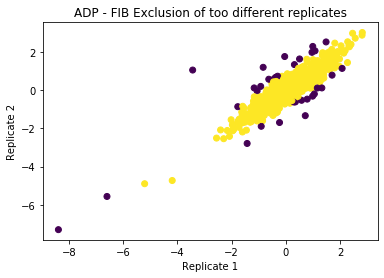

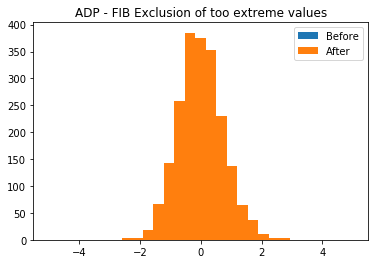

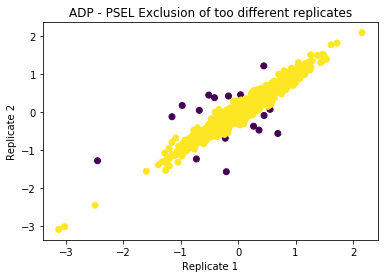

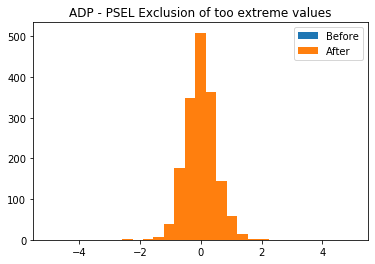

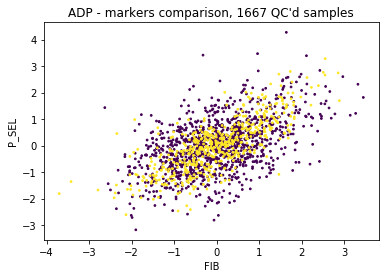

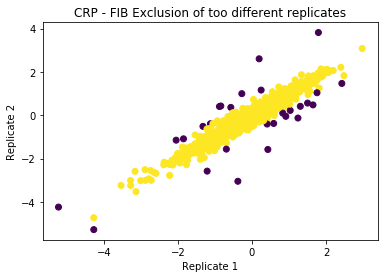

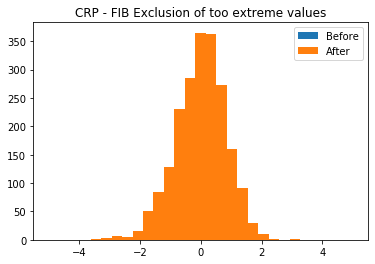

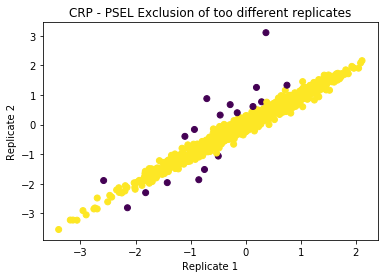

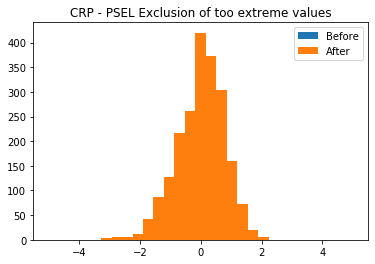

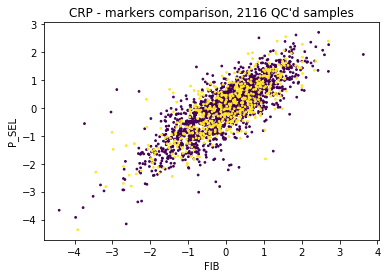

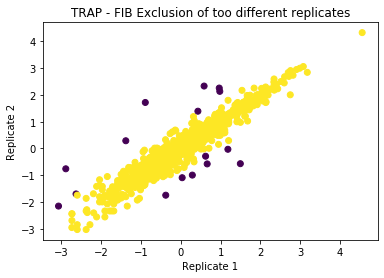

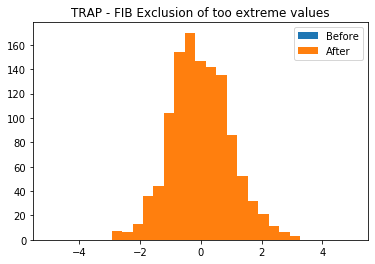

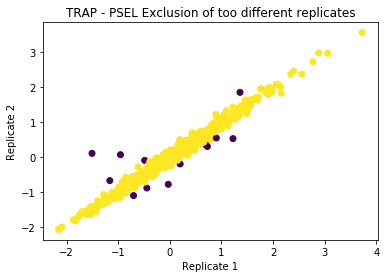

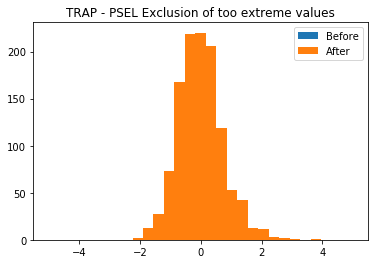

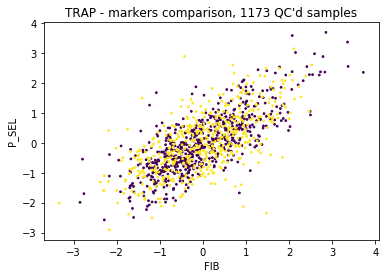

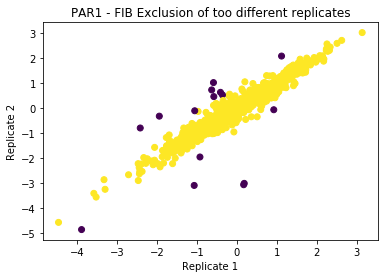

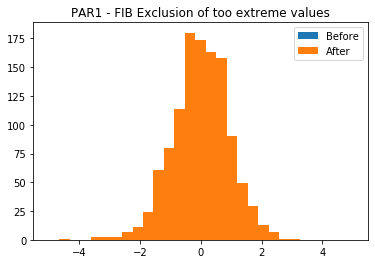

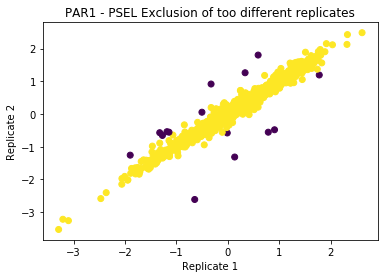

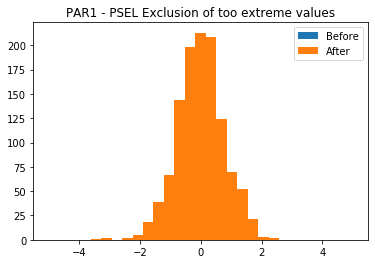

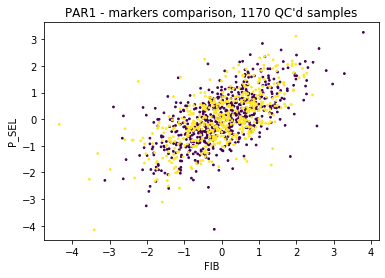

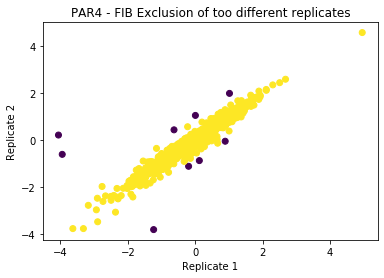

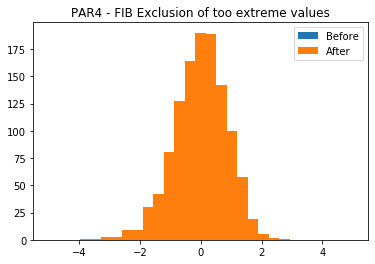

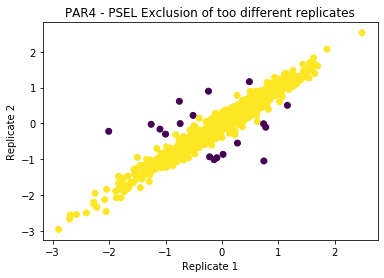

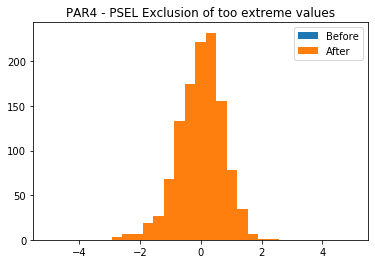

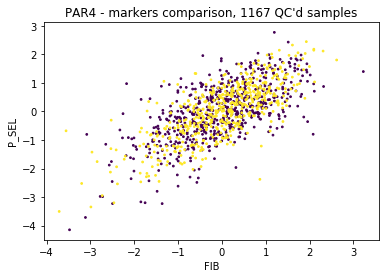

In [88]:
# Actual QC

for ago in agonists:
    for marker in ["FIB", "PSEL"]:
        df["%s_%s_REP_DELTA" % (ago, marker)] = (df["%s_%s_1" % (ago, marker)] - df["%s_%s_2" % (ago, marker)])
        df["%s_%s_REP_OK" % (ago, marker)] = df["%s_%s_REP_DELTA" % (ago, marker)].abs() < 4*df["%s_%s_REP_DELTA" % (ago, marker)].abs().std()
        df["%s_%s" % (ago, marker)] = 0.5*(df["%s_%s_1" % (ago, marker)] + df["%s_%s_2" % (ago, marker)])
        plt.figure()
        plt.title("%s - %s Exclusion of too different replicates" % (ago, marker))
        plt.scatter(df.loc[df["OK_%s_%s" % (ago, marker)] == 1,"%s_%s_1" % (ago, marker)],
            df.loc[df["OK_%s_%s" % (ago, marker)] == 1,"%s_%s_2" % (ago, marker)],
            c = df.loc[df["OK_%s_%s" % (ago, marker)] == 1,"%s_%s_REP_OK" % (ago, marker)])
        plt.xlabel("Replicate 1")
        plt.ylabel("Replicate 2")

        df["%s_%s_VAL_OK" % (ago, marker)] = False
        for cohort in df.PROJECT.unique().tolist():
            inc_cond = (df["%s_%s_REP_OK" % (ago, marker)] == 1) & (df.PROJECT == cohort)
            df.loc[inc_cond,"%s_%s_VAL_OK" % (ago, marker)] = \
                (df.loc[inc_cond,"%s_%s" % (ago, marker)] - df.loc[inc_cond,"%s_%s" % (ago, marker)].mean()).abs() \
                < 5*df.loc[inc_cond,"%s_%s" % (ago, marker)].std()
        
        plt.figure()
        plt.title("%s - %s Exclusion of too extreme values" % (ago, marker))
            
        #b = np.linspace(df.loc[df["OK_%s_%s" % (ago, marker)]\
        #                *df["%s_%s_REP_OK" % (ago, marker)] == 1,"%s_%s" % (ago, marker)].min()-1,
        #               df.loc[df["OK_%s_%s" % (ago, marker)]\
        #                *df["%s_%s_REP_OK" % (ago, marker)] == 1,"%s_%s" % (ago, marker)].max()+1,30)

        b = np.linspace(-5,5,30)
        df["%s_%s_QC_OK" % (ago, marker)] = df["OK_%s_%s" % (ago, marker)]\
                        *df["%s_%s_REP_OK" % (ago, marker)]\
                        *df["%s_%s_VAL_OK" % (ago, marker)]
        df.loc[df["OK_%s_%s" % (ago,marker)]*\
                     df["%s_%s_QC_OK" % (ago,marker)] == 0,
                     "%s_%s" % (ago,marker)] = np.nan
        
        plt.hist(df.loc[df["OK_%s_%s" % (ago, marker)]\
                            *df["%s_%s_REP_OK" % (ago, marker)] == 1,"%s_%s" % (ago, marker)],bins=b,label="Before")
        plt.hist(df.loc[df["OK_%s_%s" % (ago, marker)]\
                        *df["%s_%s_REP_OK" % (ago, marker)]\
                        *df["%s_%s_VAL_OK" % (ago, marker)] == 1,"%s_%s" % (ago, marker)],bins=b,label="After")
        plt.legend()

        print("Before Normalization")
        print(df.loc[df["%s_%s_QC_OK" % (ago, marker)] == True].groupby("PROJECT")["%s_%s" % (ago, marker)].mean())
        print(df.loc[df["%s_%s_QC_OK" % (ago, marker)] == True].groupby("PROJECT")["%s_%s" % (ago, marker)].count())
        
        for cohort in df.PROJECT.unique().tolist():
            cohort_valid_cond = ~df["%s_%s" % (ago,marker)].isnull() & (df.PROJECT == cohort)
            df.loc[cohort_valid_cond,"%s_%s" % (ago,marker)] -= df.loc[cohort_valid_cond,"%s_%s" % (ago,marker)].mean()
            df.loc[cohort_valid_cond,"%s_%s" % (ago,marker)] /= df.loc[cohort_valid_cond,"%s_%s" % (ago,marker)].std()
    
    df[ago] = 0.5*(df["%s_%s" % (ago, "FIB")] + df["%s_%s" % (ago, "PSEL")])
    
    plt.figure()
    plt.title("%s - markers comparison, %d QC'd samples" % (ago, df["%s_%s_QC_OK" % (ago, marker)].sum()))
    plt.scatter(df.loc[df["%s_%s_QC_OK" % (ago, "FIB" )] & df["%s_%s_QC_OK" % (ago, "PSEL")] == True,"%s_%s" % (ago, "FIB")],
                df.loc[df["%s_%s_QC_OK" % (ago, "PSEL")] & df["%s_%s_QC_OK" % (ago, "FIB" )] == True,"%s_%s" % (ago, "PSEL")],
                c = df.loc[df["%s_%s_QC_OK" % (ago, "PSEL")] & df["%s_%s_QC_OK" % (ago, "FIB" )] == True,"PROJECT"].str.contains("4"),
                s=3)
    plt.xlabel("FIB")
    plt.ylabel("P_SEL")

In [89]:
pheno_columns = ["ADP_PSEL","ADP_FIB","ADP",
               "CRP_PSEL","CRP_FIB","CRP",
               "TRAP_PSEL","TRAP_FIB","TRAP",
               "PAR1_PSEL","PAR1_FIB","PAR1",
               "PAR4_PSEL","PAR4_FIB","PAR4"]

In [90]:
df.DATE = pd.to_datetime(df.DATE,format="%d/%m/%y")
day_1_pfc_4 = df.loc[df.PROJECT == "PFC_4","DATE"].min()
df["DAYS"] = (df.DATE - day_1_pfc_4).dt.days

In [91]:
df = df.loc[df.PROJECT.str.contains("PFC_4")]

In [92]:
df.loc[~df.ADP_FIB.isnull(),"ADP_FIB_VAL_OK"].mean()

1.0

In [93]:
for ago in agonists:
    for marker in ["FIB", "PSEL"]:
        print("%s - %s" % (ago, marker))
        print("Two replicates : \t\t%d" % df["OK_%s_%s" % (ago, marker)].sum())
        print("Coherent replicates : \t\t%d" % df["%s_%s_REP_OK" % (ago, marker)].sum())
        print("After outliers removal : \t%d" % df["%s_%s_VAL_OK" % (ago, marker)].sum())

ADP - FIB
Two replicates : 		537
Coherent replicates : 		531
After outliers removal : 	530
ADP - PSEL
Two replicates : 		537
Coherent replicates : 		535
After outliers removal : 	533
CRP - FIB
Two replicates : 		537
Coherent replicates : 		532
After outliers removal : 	531
CRP - PSEL
Two replicates : 		537
Coherent replicates : 		533
After outliers removal : 	532
TRAP - FIB
Two replicates : 		537
Coherent replicates : 		525
After outliers removal : 	525
TRAP - PSEL
Two replicates : 		537
Coherent replicates : 		528
After outliers removal : 	528
PAR1 - FIB
Two replicates : 		537
Coherent replicates : 		529
After outliers removal : 	529
PAR1 - PSEL
Two replicates : 		537
Coherent replicates : 		531
After outliers removal : 	531
PAR4 - FIB
Two replicates : 		537
Coherent replicates : 		531
After outliers removal : 	531
PAR4 - PSEL
Two replicates : 		537
Coherent replicates : 		535
After outliers removal : 	535


In [94]:
df

,PROJECT,SAMPLE_ID,DATE,REST_FIB_1,REST_FIB_2,REST_PSEL_1,REST_PSEL_2,ADP_FIB_1,ADP_FIB_2,CRP_FIB_1,...,PAR4_FIB,PAR4_FIB_VAL_OK,PAR4_FIB_QC_OK,PAR4_PSEL_REP_DELTA,PAR4_PSEL_REP_OK,PAR4_PSEL,PAR4_PSEL_VAL_OK,PAR4_PSEL_QC_OK,PAR4,DAYS
1605,PFC_4_U,C0WX14,2016-01-12,1.979151,2.007390,-0.452823,-0.392173,1.036594,1.058580,2.052054,...,1.099728,True,1,-0.144908,True,-0.685623,True,1,0.207053,-554
1606,PFC_4_U,C0WX4Z,2016-01-12,-0.735112,-2.031737,0.063618,-0.137273,0.272949,0.582431,0.547542,...,0.081331,True,1,0.069331,True,-0.166033,True,1,-0.042351,-554
1607,PFC_4_U,C0WX6V,2016-01-12,0.105676,-0.160845,-0.268550,-0.304724,-0.257389,-0.185082,0.064717,...,-1.434140,True,1,0.085186,True,-2.451255,True,1,-1.942698,-554
1608,PFC_4_U,C0WX7T,2016-01-12,-0.010914,0.576895,0.270801,0.405902,0.991922,0.957245,1.627910,...,0.416598,True,1,0.139216,True,-0.158951,True,1,0.128823,-554
1609,PFC_4_U,C0WX8R,2016-01-12,-1.117794,-0.951069,-0.234577,-0.249044,0.131977,-0.016889,0.244401,...,0.036509,True,1,-0.106476,True,0.165842,True,1,0.101175,-554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2137,PFC_4,C1A2PI,2018-11-28,-0.499027,-0.029118,-0.137659,-0.100298,-0.012903,-0.054591,-1.255076,...,-0.599321,True,1,0.092551,True,-1.631989,True,1,-1.115655,497
2138,PFC_4,C1A2RE,2018-11-29,0.508091,0.748296,-0.166792,-0.215388,0.454233,0.438132,0.905671,...,0.101606,True,1,0.149773,True,-0.816840,True,1,-0.357617,498
2139,PFC_4,C1A2TA,2018-11-29,-0.123331,-0.724070,-0.576097,-0.664206,0.015207,-0.229225,-3.277229,...,-0.441951,True,1,0.066929,True,-1.684198,True,1,-1.063075,498
2140,PFC_4,C1A2X2,2018-11-30,0.524721,-0.001618,-0.770366,-0.929216,0.908069,0.839064,0.488176,...,0.898597,True,1,0.021661,True,-1.212965,True,1,-0.157184,499


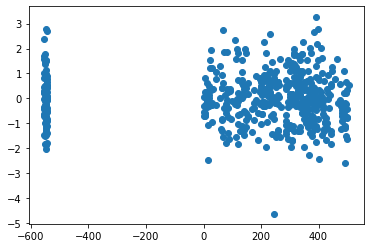

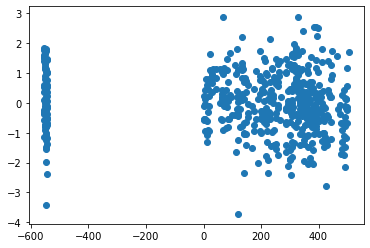

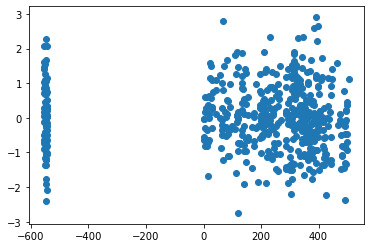

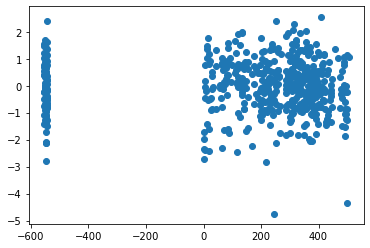

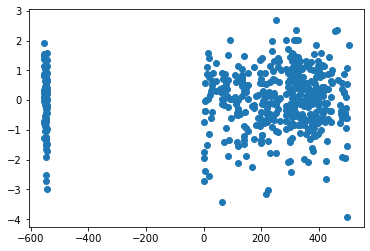

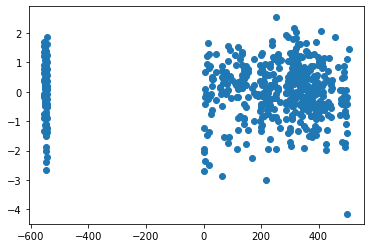

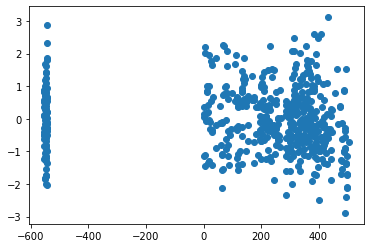

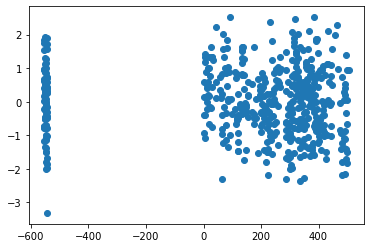

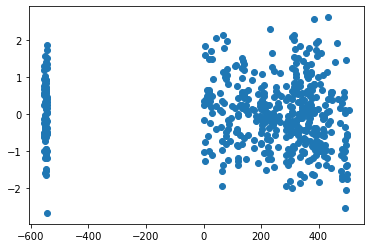

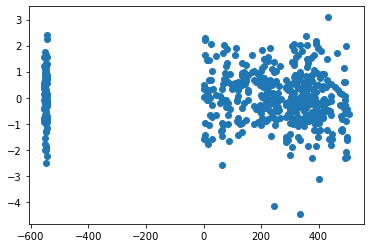

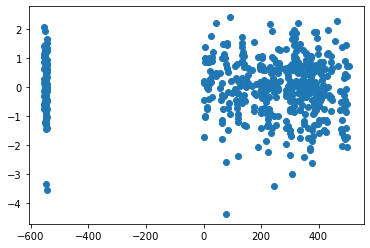

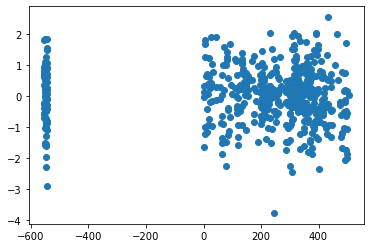

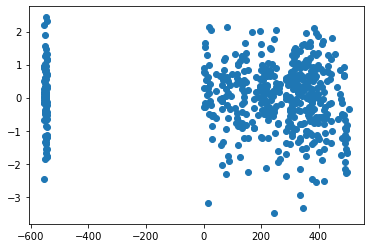

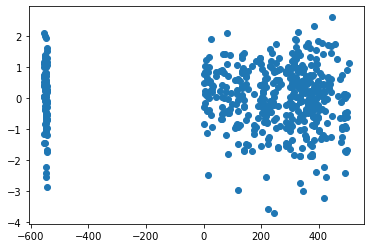

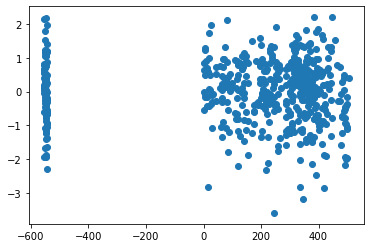

In [95]:
for c in pheno_columns:
    plt.figure()
    plt.scatter(df.DAYS,df[c])

In [96]:
mean_values = df.loc[df.isnull().sum(axis=1) == 0]

# Adjust w/ ruptures

In [97]:
sys_agesex, int_agesex = get_ages_sex()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


In [98]:
mean_values["time_col"] = pd.to_datetime(mean_values["DATE"],format="%Y-%m-%d")

In [99]:
info = mean_values.sort_values("time_col")

In [100]:
X = info[pheno_cols]

In [101]:
algo_c = rp.KernelCPD(kernel="rbf", min_size=50).fit(
    X[[c for c in pheno_cols if "_" not in c]].values
)
X = X.values

3 BKPS


<Figure size 720x288 with 0 Axes>

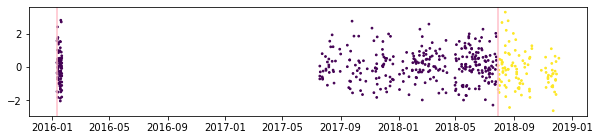

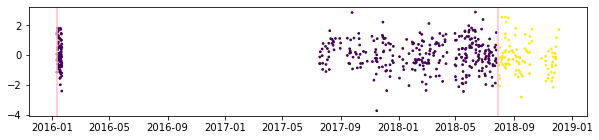

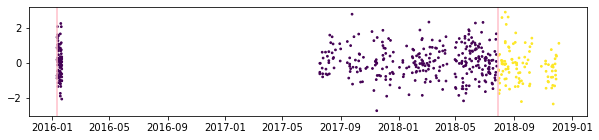

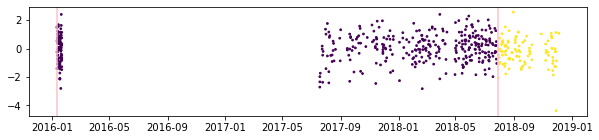

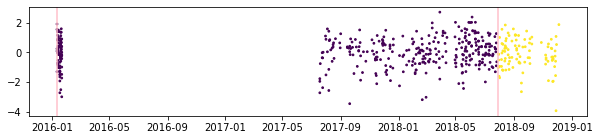

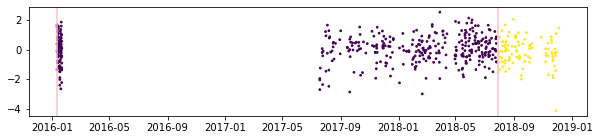

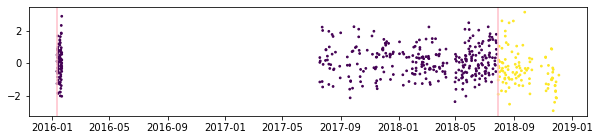

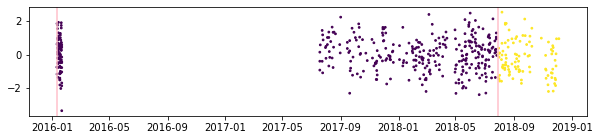

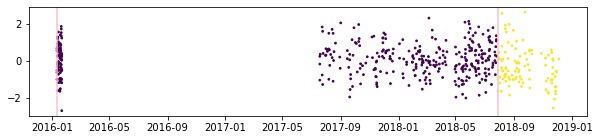

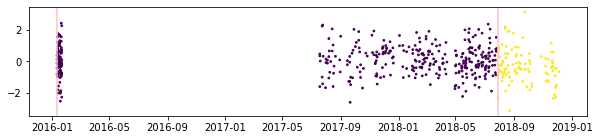

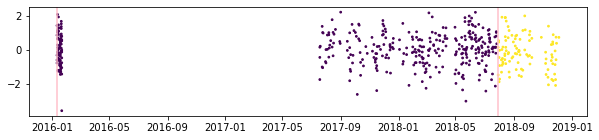

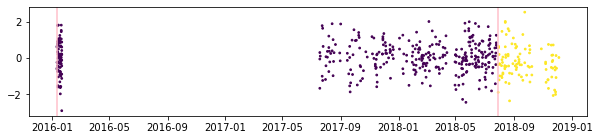

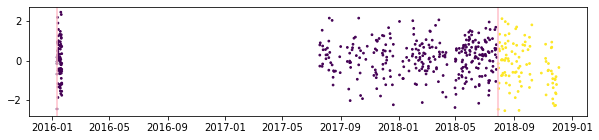

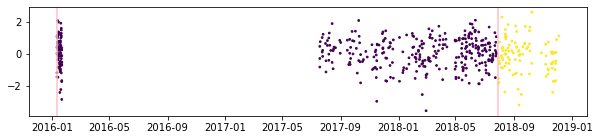

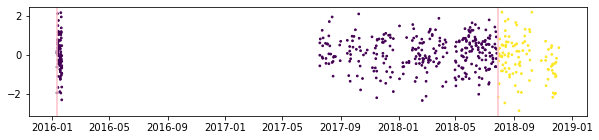

In [102]:
bkps = algo_c.predict(pen=1.6)
bkps = [0] + bkps
print("%d BKPS" % len(bkps))

info["cohort"] = 0
info["rank"] = np.arange(info.shape[0])
for b in bkps[1:]:
    info.loc[info["rank"] >= b,"cohort"] += 1
    
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.figure(figsize=(10,2))
    plt.scatter(info["time_col"],X[:,i],s=3,c=info.cohort)
    for b in bkps[:-1]:
        plt.axvline(info["time_col"].iloc[b],c="pink")

In [103]:
df = pd.merge(df,info[["SAMPLE_ID","cohort"]],left_on="SAMPLE_ID",right_on="SAMPLE_ID",how="left").sort_values("DAYS")
df["cohort"].fillna(method="ffill",inplace=True)

In [104]:
all_ = pd.merge(df,sys_agesex,left_on="SAMPLE_ID",right_index=True,how="inner")
all_ = all_.loc[all_[pheno_cols].isnull().sum(axis=1) == 0]

In [105]:
X = pd.concat([all_[["SEX","AGE"]],pd.get_dummies(all_["cohort"],drop_first=True)],axis=1)
Y = all_[pheno_cols]

In [106]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X,Y)
cohort_coefs = lm.coef_[:,2:]
print(cohort_coefs.shape)

(15, 1)


In [107]:
for c in all_.cohort.unique().tolist():
    if c == 0: continue
    df.loc[df.cohort == c,pheno_cols] -= cohort_coefs[:,int(c)-1]

# Export

In [108]:
df.to_csv("%s/processed/phenotypes.csv" % data_dir)